In [1]:
# Imports iniciales
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Defino una función más general a la pedida para no repetir código, luego
# defino funciones más específicas con lo pedido.

# Función para generar n puntos d-dimensionales provenientes de una distribución
# normal con desviación estándar igual a std, devuelve un dataframe con
# ceiling(n/2) puntos centrados en center0 y floor(n/2) puntos centrados en
# center1.
def generate_points(d, n, std, center0, center1):
  cov = std ** 2
  covMatr = np.diag([cov] * d)
  data = []

  # Si n es impar la clase 0 va a tener un elemento más que la clase 1
  lenClass1 = n // 2
  lenClass0 = n - lenClass1

  # Genero los puntos de la clase 0
  for i in range(lenClass0):
    vector = np.random.multivariate_normal(center0, covMatr).tolist() + [0]
    data += [vector]

  # Genero los puntos de la clase 1
  for i in range(lenClass1):
    vector = np.random.multivariate_normal(center1, covMatr).tolist() + [1]
    data += [vector]

  colNames = list(range(d)) + ["Class"] 

  # Devuelvo un dataframe con los puntos generados
  return pd.DataFrame(data, columns = colNames)

# Fuente: https://stackoverflow.com/a/63539077
# Dado un dataframe con 3 columnas: 0, 1, y Class. 
# Grafica los puntos dados en un plano cartesiano donde por cada fila se toma 
# a la columna 0 la coordenada x, y a la columna 1 como la coordenada y.
# Los puntos de la clase 0 se grafican en naranja y los puntos de la clase 1
# en azul.
def graph_df(df, title):
  # Separo los puntos por clase
  x0, y0 = df[0][df.Class == 0], df[1][df.Class == 0]
  x1, y1 = df[0][df.Class == 1], df[1][df.Class == 1]

  # Calculo los máximos y mínimos para tener límites en x e y del gráfico simétricos
  xmax, xmin = max(max(x0), max(x1)), min(min(x0), min(x1))
  xmax = max(abs(xmax), abs(xmin))
  
  ymax, ymin = max(max(y0), max(y1)), min(min(y0), min(y1))
  ymax = max(abs(ymax), abs(ymin))

  xmax = np.ceil(max(xmax, ymax))
  ymax = xmax
  xmin, ymin = xmax * -1, ymax * -1

  # Grafico
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.scatter(x0, y0, c = 'orange', label = "Clase 0")
  ax.scatter(x1, y1, c = 'blue', label = "Clase 1")

  ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')

  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  # ax.set_xlabel('x', size=14, labelpad=-24, x=1.03)
  # ax.set_ylabel('y', size=14, labelpad=-21, y=1.02, rotation=0)

  x_ticks = np.arange(xmin, xmax+1, 1)
  y_ticks = np.arange(ymin, ymax+1, 1)
  ax.set_xticks(x_ticks[x_ticks != 0])
  ax.set_yticks(y_ticks[y_ticks != 0])
 
  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  arrow_fmt = dict(markersize=4, color='black', clip_on=False)
  ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
  ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

  ax.legend()

  plt.title(title, size = 14, pad = 10)
  plt.show()

# Función para convertir coordenadas cartesianas a coordenadas polares
def cartesian_to_polar(x, y):
  ro = np.sqrt(x ** 2 + y ** 2)

  if (x > 0 and y >= 0):
    theta = np.arctan(y / x)
  elif (x == 0 and y > 0):
    theta = np.pi / 2
  elif (x < 0):
    theta = np.arctan(y / x) + np.pi
  elif (x == 0 and y < 0):
    theta = (3 * np.pi) / 2
  elif (x > 0 and y < 0):
    theta = np.arctan(y / x) + 2 * np.pi

  return ro, theta

# Esta función dado un n genera n puntos distribuidos uniformemente sobre los ejes
# x e y que se encuentren en un círculo de radio 1 con centro en (0, 0).
# Devuelve un dataframe donde n/2 puntos pertenecen a la clase 0 donde estos se
# encuentran en las curvas ro = theta/4pi y ro = (theta + pi)/4pi (en polares), 
# el resto de los n/2 puntos pertenecen a la clase 1. 
def generate_points_polar(n):
  data = []
  radius = 1
  centerx, centery = 0, 0
  
  # Si n es impar la clase 0 va a tener un elemento más que la clase 1
  lenClass1 = n // 2
  lenClass0 = n - lenClass1

  # Ints para iterar sobre la cantidad actual de puntos generados para cada clase
  cantClass0 = 0
  cantClass1 = 0

  # Genero puntos hasta obtener la cantidad necesaria en cada clase
  while (cantClass0 < lenClass0 or cantClass1 < lenClass1):
    # Genero punto al azar con distribución uniforme en sistema de referencia x-y
    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1)

    # Calculo sus coordenadas polares
    ro, theta = cartesian_to_polar(x, y)

    # Si no está dentro del círculo lo ignoro
    if ro <= 1:
      betweenCurves = False
      # Si está entre las dos curvas dadas y faltan puntos la clase 0 lo agrego en esa clase.
      for theta0 in [theta + (2 * np.pi * i) for i in range(-1, 6)]:
        if (theta0 / (4 * np.pi)) <= ro and ro <= ((theta0 + np.pi) / (4 * np.pi)):
          if cantClass0 < lenClass0:
            data += [(x, y, 0)]
            cantClass0 += 1
          betweenCurves = True
          continue
      # Si no estaba entre las curvas y faltan puntos en la clase 1, lo agrego ahí.
      if cantClass1 < lenClass1 and not betweenCurves:
        data += [(x, y, 1)]
        cantClass1 += 1

  colNames = [0, 1, "Class"] 

  # Devuelvo un dataframe con los puntos generados
  return pd.DataFrame(data, columns = colNames)

# Genero un dataframe con los puntos para el problema "diagonal"
def generate_diagonal(d, n, C):
  return generate_points(d, n, C * np.sqrt(d), [-1] * d, [1] * d)

# Genero un dataframe con los puntos para el problema "paralelo"
def generate_parallel(d, n, C):
  # (1, 0, ... , 0)
  center0 = [1] + ([0] * (d - 1))
  # (-1, 0, ... , 0)
  center1 = [-1] + ([0] * (d - 1))
  return generate_points(d, n, C, center0, center1)

# A partir de un dataframe, lo tomo como conjunto de entrenamiento y entreno
# un árbol a partir de él
def train_tree(df):
  X_train, y_train = df[[0, 1]], df['Class']
  clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
  clf.fit(X_train, y_train)

  return clf

# A partir de un conjunto de datos y un árbol de decisión, predigo sobre 
# el conjunto dado
def predict_df(df_test, clf):
  X_test = df_test[[0, 1]]
  predict = clf.predict(X_test)
  df_predict = df_test.copy(deep = True)
  df_predict['Class'] = predict
  return df_predict

# Defino una función para graficar los errores de las predicciones sobre los
# conjuntos de entrenamiento y test
def graph_errors(errors_df, which):
  fig, ax = plt.subplots(figsize=(10, 10))

  colors = ["blue", "orange", "green", "red", "magenta", "purple"]
  classes = pd.unique(errors_df['Class'])

  for (p, c) in zip(classes, colors):
   df = errors_df[errors_df['Class'] == p]
   df = df.groupby(which).mean()
   df = df.reset_index()
   plt.plot(df[which], df['Error'], color=c, marker='o')

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(classes, ncol = 4)
  plt.xlabel(which, size=14, labelpad=15)
  plt.ylabel('Error', size=14, labelpad=15)

# Defino una función para graficar la cantidad de nodos de los árboles resultantes
# a partir de los datos de entrenamiento
def graph_nodes_count(count_df):
  fig, ax = plt.subplots(figsize=(10, 10))

  colors = ["blue", "orange"]
  classes = pd.unique(count_df['Class'])

  for (p, c) in zip(classes, colors):
   df = count_df[count_df['Class'] == p]
   df = df.groupby('n').mean()
   df = df.reset_index()
   plt.plot(df['n'], df['Nodes'], color=c, marker='o')

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(classes, ncol = 4)
  plt.xlabel('n', size=14, labelpad=15)
  plt.ylabel('Nodes', size=14, labelpad=15)

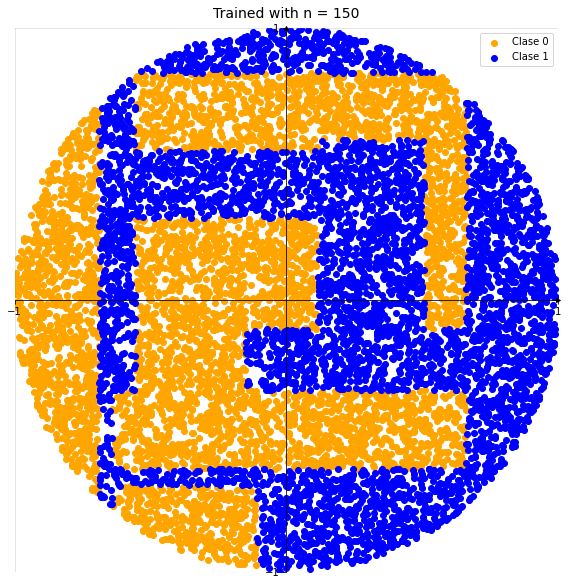

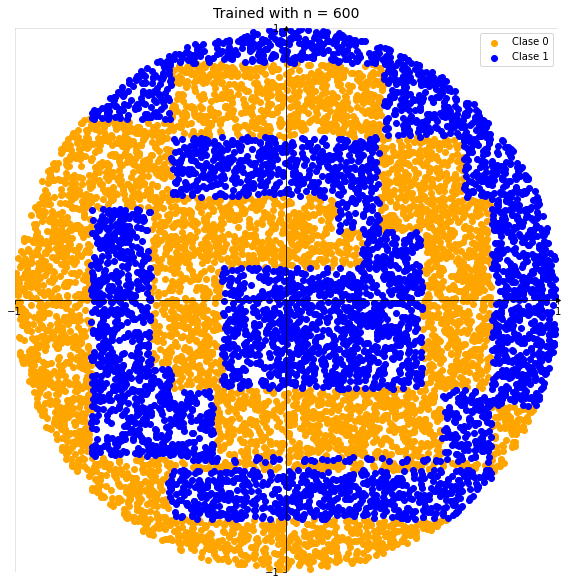

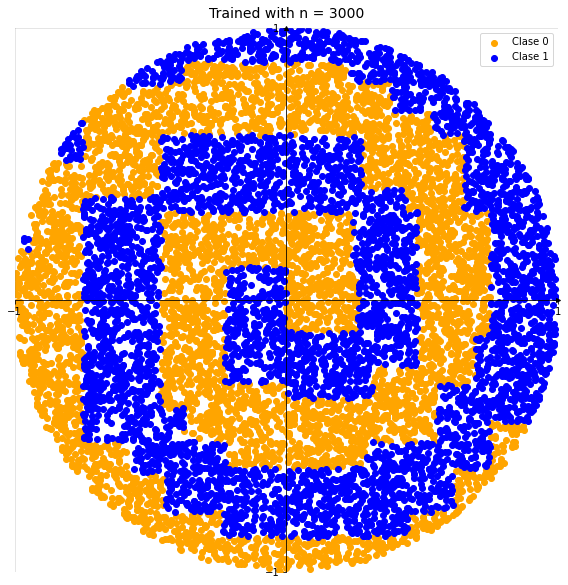

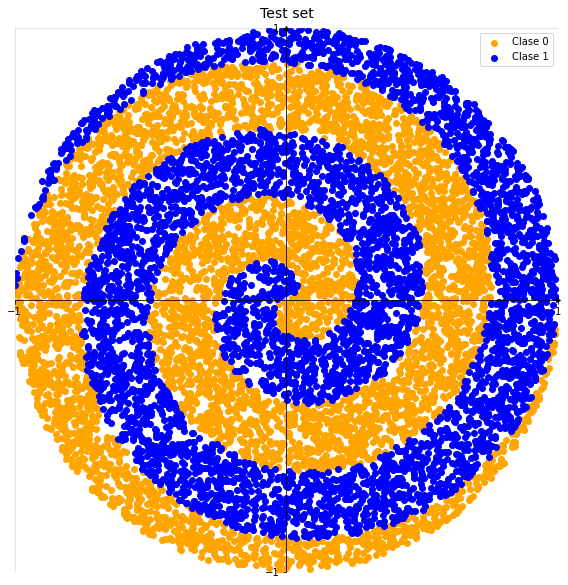

In [3]:
# Ejercicio 1
# Genero los datos de entrenamiento
df_train_spirals_150 = generate_points_polar(150)
df_train_spirals_600 = generate_points_polar(600)
df_train_spirals_3000 = generate_points_polar(3000)
# Genero el conjunto de test
df_test_spirals_10000 = generate_points_polar(10000)

# Entreno los árboles correspondientes
clf_spiral_150 = train_tree(df_train_spirals_150)
clf_spiral_600 = train_tree(df_train_spirals_600)
clf_spiral_3000 = train_tree(df_train_spirals_3000)

# Predigo
predict_spiral_150 = predict_df(df_test_spirals_10000, clf_spiral_150)
predict_spiral_600 = predict_df(df_test_spirals_10000, clf_spiral_600)
predict_spiral_3000 = predict_df(df_test_spirals_10000, clf_spiral_3000)

# Grafico los resultados de las predicciones
graph_df(predict_spiral_150, "Trained with n = 150")
graph_df(predict_spiral_600, "Trained with n = 600")
graph_df(predict_spiral_3000, "Trained with n = 3000")
# También grafico el conjunto de test original para comparar los resultados con lo esperado
graph_df(df_test_spirals_10000, "Test set")

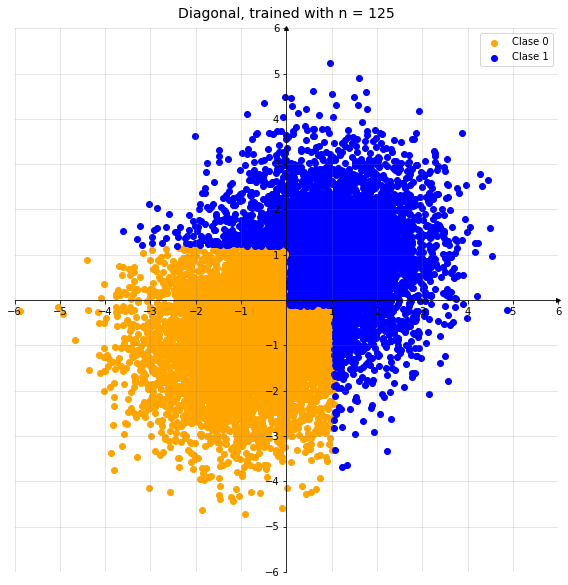

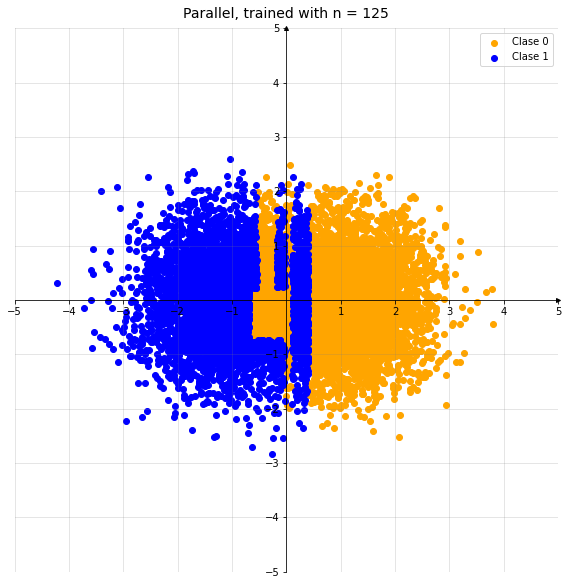

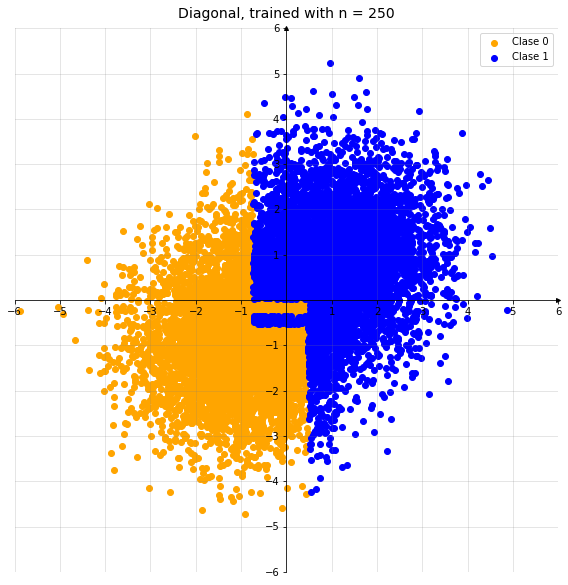

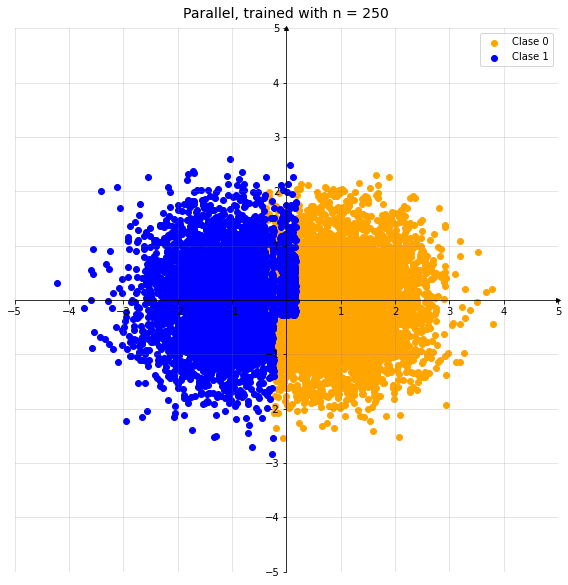

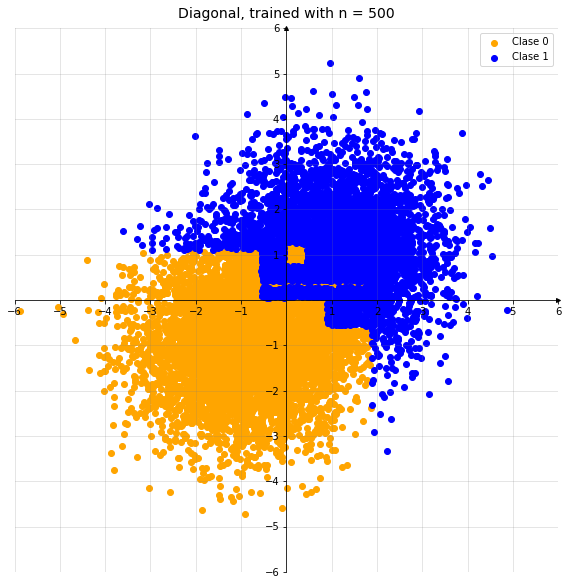

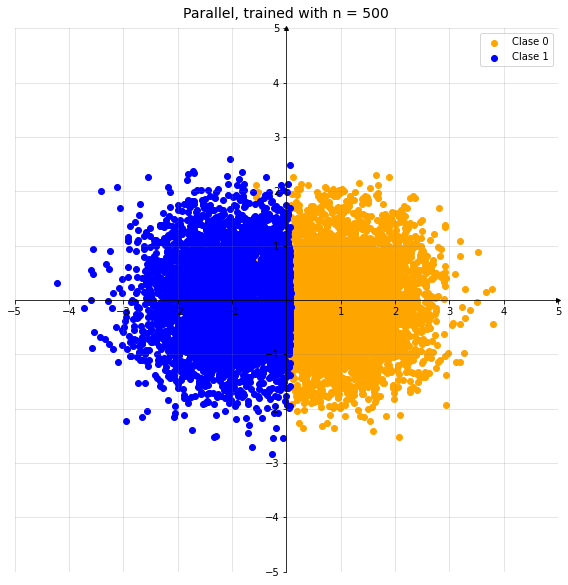

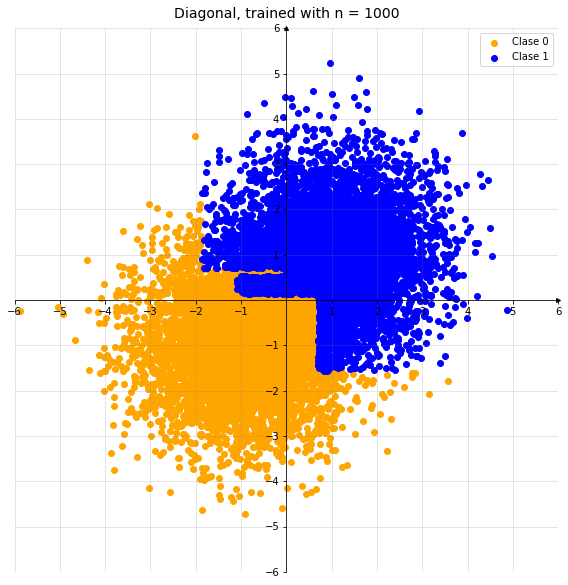

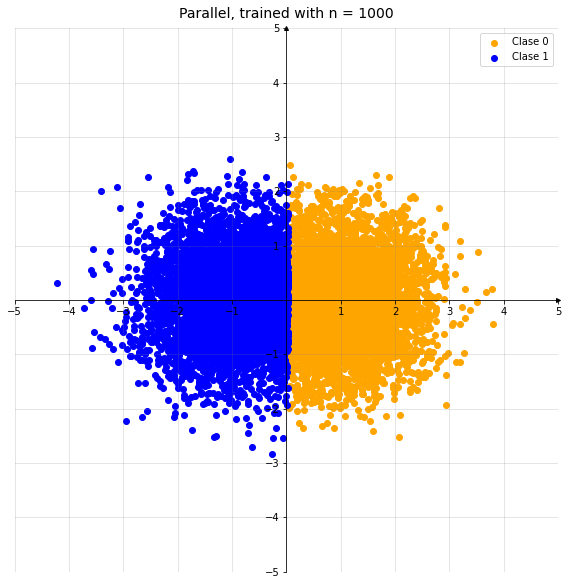

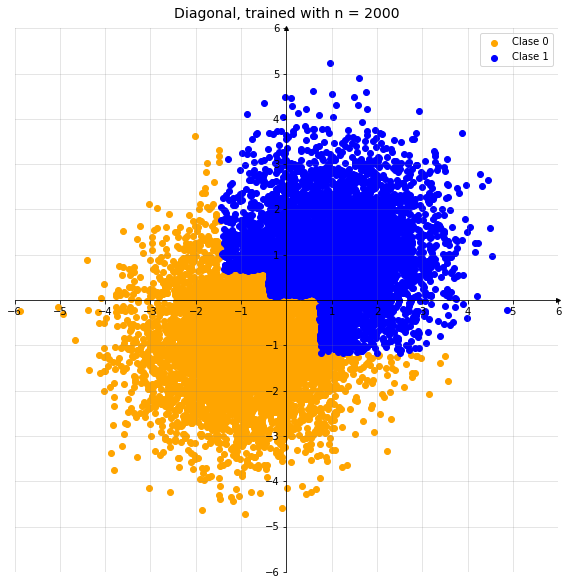

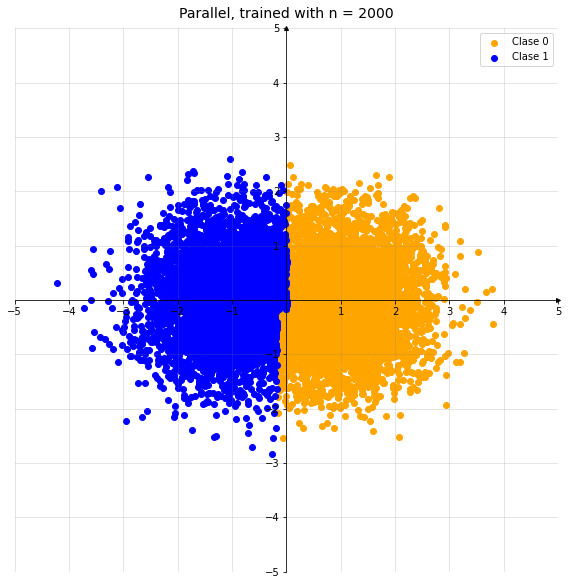

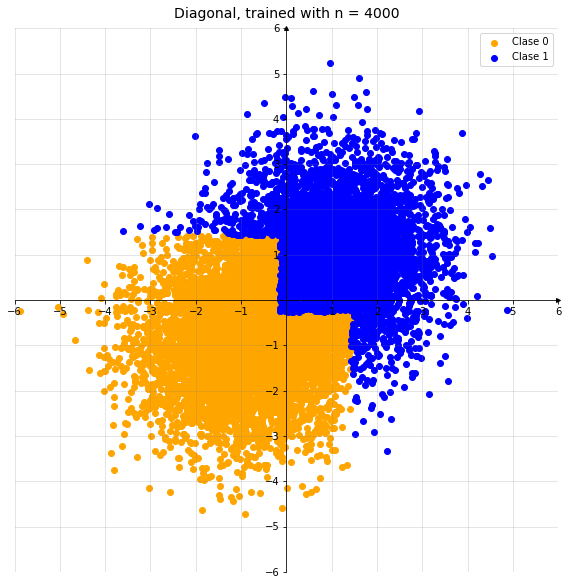

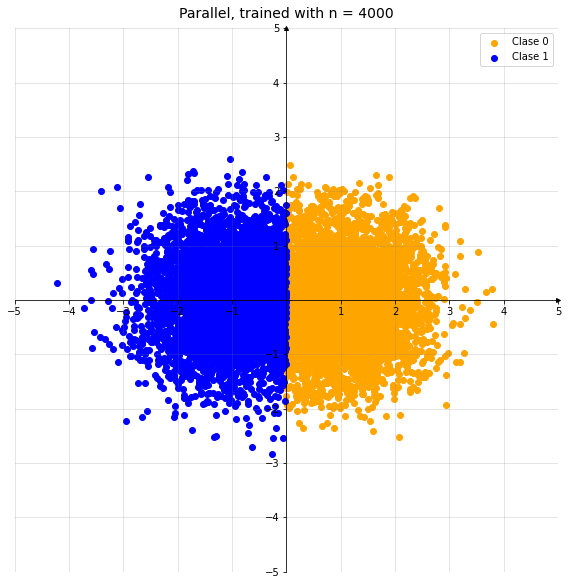

In [4]:
# Ejercicio 2
# Genero los conjuntos de test
df_test_diagonal_10000 = generate_diagonal(2, 10000, 0.78)
df_test_parallel_10000 = generate_parallel(2, 10000, 0.78)

n_points = [125, 250, 500, 1000, 2000, 4000]

errors = []
nodes_counts = []

for n in n_points:
  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(2, n, 0.78)
    df_train_para = generate_parallel(2, n, 0.78)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_df(df_train_diag, clf_diag)
    predict_test_diag = predict_df(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_df(df_train_para, clf_para)
    predict_test_para = predict_df(df_test_parallel_10000, clf_para)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), n, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), n, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), n, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), n, "Test parallel"])

    # Calculo la cuenta de nodos para el arbol
    nodes_counts.append([clf_diag.tree_.node_count, n, "Diagonal"])
    nodes_counts.append([clf_para.tree_.node_count, n, "Parallel"])

  # Grafico fuera del loop sobre i para graficar solo los últimos resultados de cada n
  graph_df(predict_test_diag, "Diagonal, trained with n = " + str(n))
  graph_df(predict_test_para, "Parallel, trained with n = " + str(n))

# Creo los dataframes con los errores y conteos de nodos
ej2_errors_df = pd.DataFrame(errors, columns = ["Error", "n", "Class"])
ej2_nodes_counts_df = pd.DataFrame(nodes_counts, columns = ["Nodes", "n", "Class"])

graph_errors(ej2_errors_df, 'n')
graph_nodes_count(ej2_nodes_counts_df)

In [26]:
def optimal_classifier(df_test, center0, center1):
  df_optimal = df_test.copy(deep = True)
  points_list = df_test.drop('Class', axis = 1).values.tolist()

  classes = []

  center0 = np.array(center0)
  center1 = np.array(center1)

  for point in [np.array(p) for p in points_list]:
    distance0 = np.sqrt(np.sum(np.square(point - center0)))
    distance1 = np.sqrt(np.sum(np.square(point - center1)))

    if distance0 <= distance1:
      classes.append(0)
    else:
      classes.append(1)

  df_optimal['Class'] = classes

  return df_optimal

def optimal_diagonal(df_test, d):
  center0 = [-1] * d
  center1 = [1] * d
  return optimal_classifier(df_test, center0, center1)

def optimal_parallel(df_test, d):
  center0 = [1] + ([0] * (d - 1))
  center1 = [-1] + ([0] * (d - 1))
  return optimal_classifier(df_test, center0, center1)

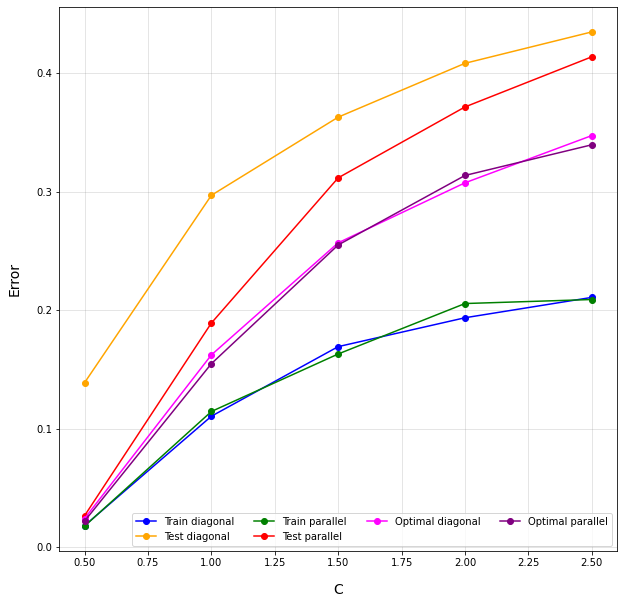

In [27]:
# Ejercicio 3

errors = []
nodes_counts = []

for C in np.arange(0.5, 3, 0.5):
  # Genero los conjuntos de test
  df_test_diagonal_10000 = generate_diagonal(5, 10000, C)
  df_test_parallel_10000 = generate_parallel(5, 10000, C)

  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(2, 250, C)
    df_train_para = generate_parallel(2, 250, C)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_df(df_train_diag, clf_diag)
    predict_test_diag = predict_df(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_df(df_train_para, clf_para)
    predict_test_para = predict_df(df_test_parallel_10000, clf_para)
    optimal_diag = optimal_diagonal(df_test_diagonal_10000, 5)
    optimal_para = optimal_parallel(df_test_parallel_10000, 5)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), C, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), C, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), C, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), C, "Test parallel"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], optimal_diag['Class']), C, "Optimal diagonal"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], optimal_para['Class']), C, "Optimal parallel"])

# Creo el dataframes con los errores
ej3_errors_df = pd.DataFrame(errors, columns = ["Error", "C", "Class"])

graph_errors(ej3_errors_df, 'C')

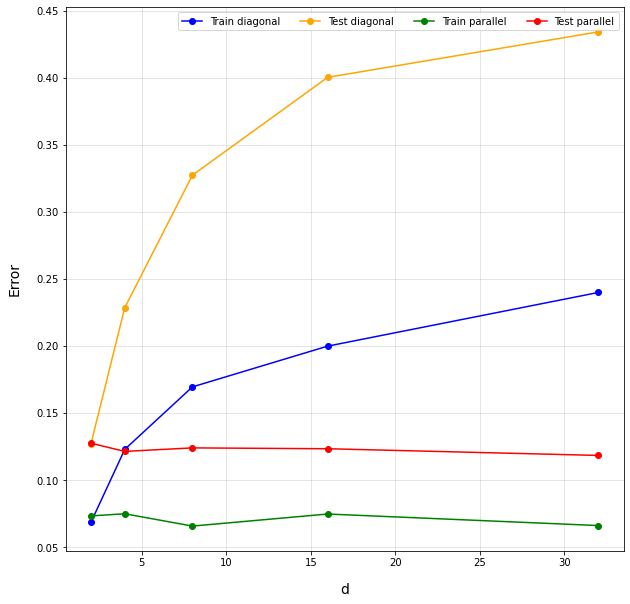

In [25]:
# Ejercicio 4
errors = []

for d in [2 ** i for i in range(1, 6)]:
  # Genero los conjuntos de test
  df_test_diagonal_10000 = generate_diagonal(d, 10000, 0.78)
  df_test_parallel_10000 = generate_parallel(d, 10000, 0.78)

  for i in range(20):
    # Genero los conjuntos de entrenamiento
    df_train_diag = generate_diagonal(d, 250, 0.78)
    df_train_para = generate_parallel(d, 250, 0.78)
    
    # Entreno los árboles
    clf_diag = train_tree(df_train_diag)
    clf_para = train_tree(df_train_para)
    
    # Predigo sobre los conjunto de test y los de entrenamiento
    predict_train_diag = predict_df(df_train_diag, clf_diag)
    predict_test_diag = predict_df(df_test_diagonal_10000, clf_diag)
    predict_train_para = predict_df(df_train_para, clf_para)
    predict_test_para = predict_df(df_test_parallel_10000, clf_para)

    # Calculo los errores
    errors.append([1 - accuracy_score(df_train_diag['Class'], predict_train_diag['Class']), d, "Train diagonal"])
    errors.append([1 - accuracy_score(df_test_diagonal_10000['Class'], predict_test_diag['Class']), d, "Test diagonal"])
    errors.append([1 - accuracy_score(df_train_para['Class'], predict_train_para['Class']), d, "Train parallel"])
    errors.append([1 - accuracy_score(df_test_parallel_10000['Class'], predict_test_para['Class']), d, "Test parallel"])

# Creo el dataframes con los errores
ej4_errors_df = pd.DataFrame(errors, columns = ["Error", "d", "Class"])

graph_errors(ej4_errors_df, "d")

Error de predecir sobre el árbol obtenido: 0.5


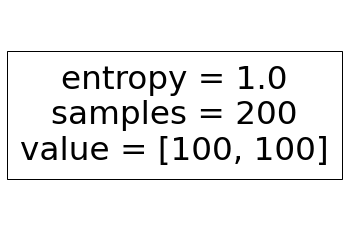

In [24]:
# Ejercicio 5
df_xor = pd.read_csv("xor.csv", header=None, names=[0, 1, 'Class'])

clf_xor = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.03,random_state=0,min_samples_leaf=5)
clf_xor.fit(df_xor[[0, 1]], df_xor['Class'])
tree.plot_tree(clf_xor)
predict_xor = predict_df(df_xor, clf_xor)

print("Error de predecir sobre el árbol obtenido:", 1 - accuracy_score(df_xor['Class'], predict_xor['Class']))